In [27]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import bomeba0 as bmb

In [41]:
n = 10
prot = bmb.Protein('A'*9)
ang = np.random.uniform(-180, 180, size=(n, 2))
for i in range(0, len(prot)):
    phi, psi = ang[i]
    prot.set_phi(i, phi)
    prot.set_psi(i, psi)

In [42]:
def fragments(prot):
    """
    Takes a Protein object and returns a list.
    of it's fragmented coordinates.
    ----------------
    Parameters
    ----------------
    prot: Protein object
    
    -----------------
    Returns
    -----------------
    selec: List of selected coordinates.
    """

    xyz = prot.coords
    boxes = bmb.OBB._little_boxes(prot)
    selec =  [xyz.take(i, 0) for i in  boxes]
    return selec

<IPython.core.display.Javascript object>


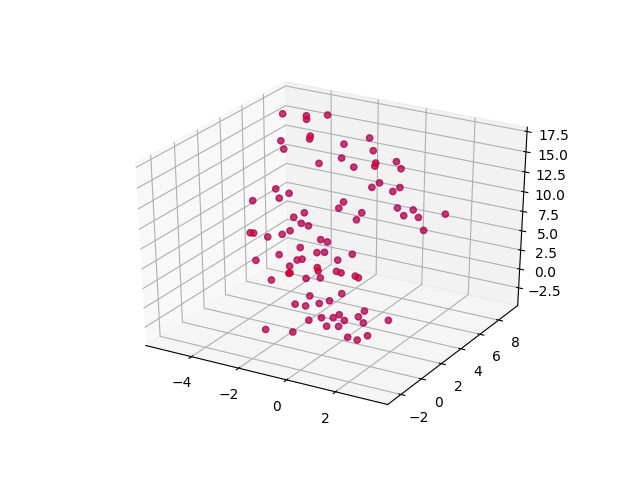

In [43]:
selec = fragments(prot)
frag = np.concatenate(selec)
# check frag is the same as xyz
xyz = prot.coords
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c='b', alpha=0.5)
ax.scatter(frag[:,0], frag[:,1], frag[:,2], c='r', alpha=0.5)

In [36]:
class Node:    
    
    """Constructor to create a new node"""
    
    def __init__(self, coord, parents, children):
        self.obb = vertex_OBB(coord)
        self.parents = parents
        self.children = children
        
    def __str__(self):
        return '{}'.format(self.obb, self.parents, self.children)

def vertex_OBB(XYZ):
        """
        Computes the 8 vertex of the Oriented Bounding Box
        -----------
        Parameters:
        -----------
        XYZ : array of shape (n,3). Contains the coordinates of
              the atoms to be enclosed by the OBB.  
              
        -----------
        Returns:
        -----------
        vertex : OBB coordinates
        eigen_vecs : transformation matrix
        vertex_no : OBB without the Sr addition
        """
        # Compute scatter matrix
        #scat = XYZ.T @ XYZ
        # compute covariance matrix
        scat = np.cov([xyz[:,0], xyz[:,1], xyz[:,2]])
        # Compute singular values or eigenvalues
        eigen_vecs, _, _ = np.linalg.svd(scat)
        #_, eigen_vecs = np.linalg.eig(scat)

        # project XY onto the "principal axes"
        XYZ_proj = XYZ @ eigen_vecs

        # compute min/max values (or whatever you need)
        min_x, min_y, min_z = np.min(XYZ_proj, 0)
        max_x, max_y, max_z = np.max(XYZ_proj, 0)

        #S radius
        Sr = 1.80

        ver_proj_S = np.array([[min_x - Sr, min_y - Sr, min_z - Sr],#
                         [min_x - Sr, max_y + Sr, min_z - Sr],#
                         [max_x + Sr, min_y - Sr, min_z - Sr],
                         [max_x + Sr, max_y + Sr, min_z - Sr],
                         [min_x - Sr, min_y - Sr, max_z + Sr],#
                         [min_x - Sr, max_y + Sr, max_z + Sr],#
                         [max_x + Sr, min_y - Sr, max_z + Sr],
                         [max_x + Sr, max_y + Sr, max_z + Sr]])
        
        ver_proj = np.array([[min_x , min_y , min_z ],#
                         [min_x, max_y, min_z ],#
                         [max_x, min_y, min_z ],
                         [max_x, max_y, min_z],
                         [min_x, min_y, max_z],#
                         [min_x, max_y, max_z],#
                         [max_x, min_y, max_z],
                         [max_x, max_y, max_z]])

        # project min/max values back to the original system
        vertex = ver_proj_S @ eigen_vecs.T
        vertex_no = ver_proj @ eigen_vecs.T # Vertex is oriented and not scaled!!
        #ver = ver_proj @ eigen_vecs.T # use this with eigenvalues
        return vertex, eigen_vecs, vertex_no
    

def create_nodes(selec): 
    
        """
        Creates every node
        -----------
        Parameters:
        -----------
        selec : List of arrays containing selection coordinates
        
        -----------
        Returns:
        -----------
        nodes: (list of lists) every level in the hierarchy and every node in each level
        """
        lower_layer = []
        for i in selec:
            node = Node(i, parents = 1, children = 0)
            lower_layer.append(node)

        combine = [lower_layer[n:n+2] for n in range(0, len(lower_layer), 2)]
        nodes = [lower_layer]

        for i in range(len(combine)-1):
            layer = []
            for node_list in combine:
                try:
                    c = np.concatenate((node_list[0].obb[2], node_list[1].obb[2]))
                    layer.append(Node(c, parents = 1, children = 2))
                except IndexError: 
                    layer.append(node_list[0])
            nodes.append(layer)
            combine = [layer[n:n+2] for n in range(0, len(layer), 2)]        
        return nodes

In [44]:
nodes = create_nodes(selec)

<IPython.core.display.Javascript object>


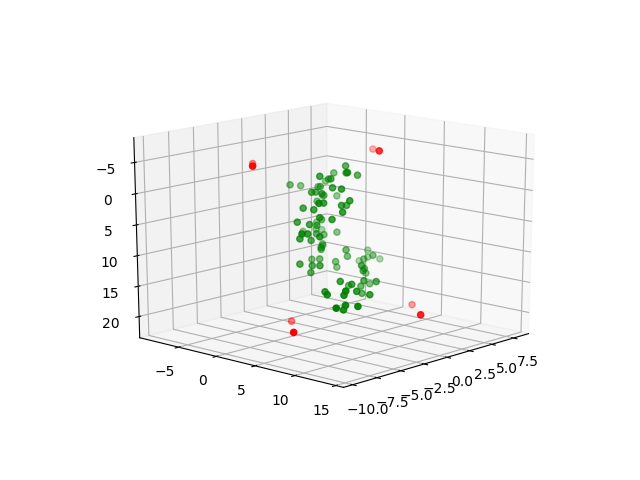

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(frag[:,0], frag[:,1], frag[:,2], c='g')

#ax.scatter(q[:,0], q[:,1], q[:,2], c='m')


lv1 = -1
lv2 = -2
bx = 0
ax.scatter(nodes[lv1][0].obb[0][:,0],  nodes[lv1][0].obb[0][:,1], nodes[lv1][0].obb[0][:,2], c ='r')#
#ax.scatter(nodes[lv2][bx].obb[0][:,0],  nodes[lv2][bx].obb[0][:,1], nodes[lv2][bx].obb[0][:,2], c ='y')#
#ax.scatter(nodes[lv2][bx+1].obb[0][:,0],  nodes[lv2][bx+1].obb[0][:,1], nodes[lv2][bx+1].obb[0][:,2], c ='m')#


#### box for whole protein is the same than the one computed bottom-up
box = vertex_OBB(frag)[0]
#ax.scatter(box[:,0] , box[:,1] , box[:,2], c='m')

##tight box
#ax.scatter(nodes[lv1][bx].obb[2][:,0],  nodes[lv1][bx].obb[2][:,1], nodes[lv1][bx].obb[2][:,2], c ='y')#